Analysis of the H2O and DMMP Dataset

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import homcloud.interface as hc
import glob
import os
import skimage
import skimage.io
import scipy
import subprocess
import tqdm
from sklearn.decomposition import PCA

from sklearn.svm import LinearSVC as lsvm  
from sklearn.decomposition import PCA  
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [9, 6]

In our analysis we analyze the grayscale images associated with a given time frame. Ths code extracts these images, converts them to gray scale, and stacks then into an indexable database.

In [2]:
def Stack_images(path_loc,time_min,time_max,mode):
    flats = []
    path = glob.glob(path_loc)
    Times = []
    data = []
    dims = []
    rawimgs = []
    
    for i in path:
        Time = np.int(os.path.basename(i)[11:14])
        Times.append(Time)
      
    Times = np.hstack(Times)
       
    #Time Frame    
    
    a = np.where((Times > time_min) & (Times < time_max))[0].astype(int)
    
    Pathtime = [path[i] for i in a]

    if mode == 0:
    
        for j in Pathtime:
            image = skimage.io.imread(j)
            grayimage = skimage.color.rgb2gray(image)
            grayimage = (grayimage - np.min(grayimage))/(np.max(grayimage) - np.min(grayimage))
            flats.append(grayimage)
            dims.append([grayimage.shape[0],grayimage.shape[1]])
            data = flats
            rawimgs.append(image)
        
    else:
        
        for j in Pathtime:
            image = skimage.io.imread(j)
            hueimage = skimage.color.rgb2lab(image)[:,:,1]
            hueimage = (hueimage - np.min(hueimage))/(np.max(hueimage) - np.min(hueimage))
            flats.append(hueimage)
            dims.append([hueimage.shape[0],hueimage.shape[1]])
            data = flats
            rawimgs.append(image)
    
    return data,dims,rawimgs

In [3]:
data_30,dims_30,rawimgs_30 = Stack_images(r"DMMP\*.jpg",9,20,0)

data_50,dims_50,rawimgs_50 = Stack_images(r"Water\*.jpg",9,20,0)

Here we use HOMCLOUD to perform a morse filtration on our images.

We comment out cells 4 and 5 to speed up computation, the data is recorded in the "pd" and "pd1" folders.

In [4]:
# U = 1100
# os.makedirs(r"pd", exist_ok=True)
# for i in range(U):
#     hc.PDList.from_bitmap_levelset(data_30[i], save_to=r"pd\pd{}.idiagram".format(i))

In [5]:
# os.makedirs(r"pd1", exist_ok=True)  
# for i in range(U):
#     hc.PDList.from_bitmap_levelset(data_50[i],save_to="pd1\pd1{}.idiagram".format(i))

In [6]:
pds = [hc.PDList(r"pd\pd{}.idiagram".format(i)).dth_diagram(1) for i in range(U)]

In [7]:
pd1s = [hc.PDList(r"pd1\pd1{}.idiagram".format(i)).dth_diagram(1) for i in range(U)]

Here we create a smoothed mesh via the persistence image technique with a gaussian kernel.

In [8]:
mesh = hc.PIVectorizerMesh((.13,1), 128, sigma=0.02, weight="none")

In [9]:
pdvects30 = np.vstack([mesh.vectorize(pd) for pd in pds])

In [10]:
pdvects50 = np.vstack([mesh.vectorize(pd) for pd in pd1s])

In [11]:
pdtot = np.vstack([pdvects30,pdvects50])
pdtot = pdtot / pdtot.max()

In [12]:
label = np.zeros(U*2)
label[0:U] = 1

Here we create a training and testing dataset for our linear svmd model.

In [13]:
pdvects_train, pdvects_test, labels_train, labels_test = train_test_split(pdtot, label, test_size=0.3)

In [14]:
model = lsvm()

In [15]:
model.fit(pdvects_train, labels_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [16]:
model.score(pdvects_test, labels_test)

0.8606060606060606

With the trained model we want to analyze the weights and find the relevant features in our data.

In [17]:
coef = np.asarray(model.coef_)[0]

In [18]:

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

Visualize and Mask our classification weights.

Text(0.5, 14.5, 'Birth')

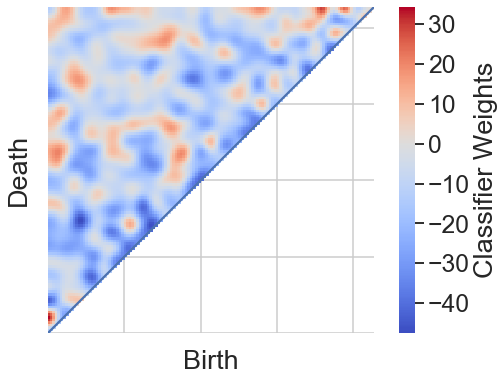

In [35]:
red = np.asarray((coef > .005)*1)
blue = np.asarray((coef < -.15)*1)

red_area = mesh.mask_from_vector(red)
blue_area = mesh.mask_from_vector(blue)

fig = plt.figure()
a = mesh.histogram_from_vector(coef + .000001).values*100

a[a==0] = np.nan

elev_min = 10
elev_max = -10

mask = np.zeros_like(a)
mask[np.triu_indices_from(mask)] = True

sns.axes_style("darkgrid")

plt.plot([0,400],[0,400])

sns.heatmap(a,cmap = "coolwarm",mask=mask,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=0,vmin=elev_min, vmax=elev_max),cbar_kws={'label': 'Classifier Weights'},square = True)
plt.grid(True)
plt.xticks(np.linspace(0,120,num=5))
plt.yticks(np.linspace(0,120,num=5))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places

plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_ticklabels([])
plt.gca().axes.get_yaxis().set_ticklabels([])
plt.ylabel("Death")
plt.xlabel("Birth")


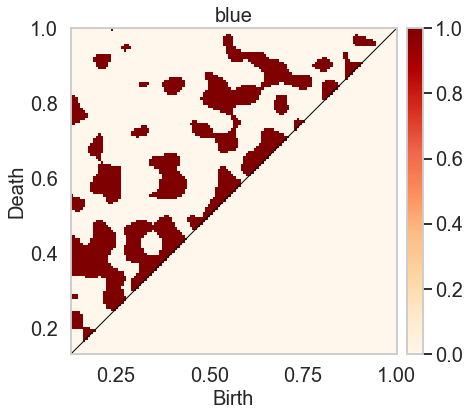

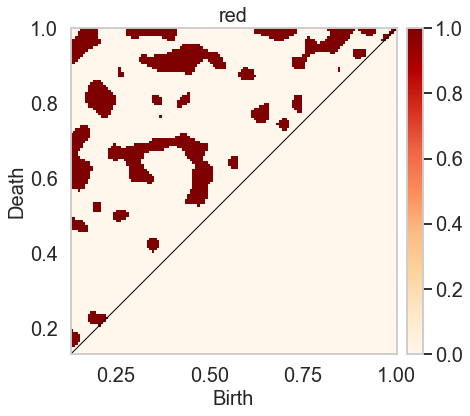

In [36]:
blue_area.plot(title="blue")
plt.savefig("so2bluemask.svg",transparent = True)
red_area.plot(title="red")
plt.savefig("so2redmask.svg",transparent = True)

Select a representative datapoint to visualize the features the classifier identifies as important.

In [37]:
wind = 600
dind = 1040
pairs_in_blue_0 = blue_area.filter_pairs(pds[wind].pairs())
pairs_in_red_0 = red_area.filter_pairs(pds[dind].pairs())

In [38]:
len(pairs_in_blue_0), len(pairs_in_red_0)

(2, 4)

In [39]:
pairs_in_blue_100 = blue_area.filter_pairs(pd1s[wind].pairs())
pairs_in_red_100 = red_area.filter_pairs(pd1s[dind].pairs())

In [40]:
len(pairs_in_blue_100), len(pairs_in_red_100)

(9, 0)

In [41]:
hc.BitmapPHTreesPair.from_bitmap_levelset(data_50[wind], "sublevel", save_to="grayscale.p2mt")

In [42]:
phtrees = hc.BitmapPHTreesPair("grayscale.p2mt").codim_1_trees()

In [43]:
nodes =  blue_area.filter_pairs(phtrees.nodes)

In [44]:
a = hc.draw_volumes_on_2d_image(nodes, data_50[wind], color=(255, 0, 0), alpha=1, birth_position=(255,0,0), marker_size=0)


Inverse analysis for a water sample.

[[]]

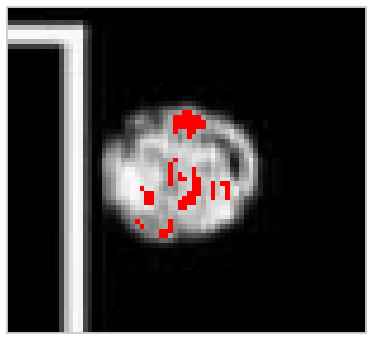

In [45]:
sns.set_style("whitegrid", {'axes.grid' : False})

plt.imshow(a)
plt.gca().set(yticks=[])
plt.gca().set(xticks=[])

In [46]:
hc.BitmapPHTreesPair.from_bitmap_levelset(data_30[dind], "sublevel", save_to="grayscale.p2mt")

In [47]:
phtrees = hc.BitmapPHTreesPair("grayscale.p2mt").codim_1_trees()

In [48]:
nodes = red_area.filter_pairs(phtrees.nodes)

Inverse analysis for a DMMP sample.

[[]]

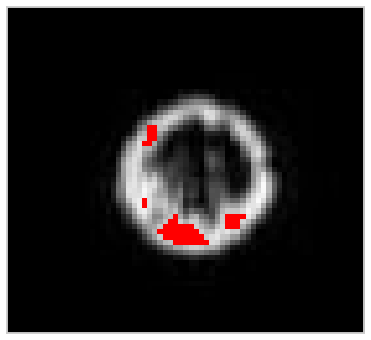

In [49]:
b = hc.draw_volumes_on_2d_image(nodes, data_30[dind], color=(255, 0, 0), alpha=1, birth_position=(255,0,0), marker_size=0)

plt.imshow(b)
plt.gca().set(yticks=[])
plt.gca().set(xticks=[])
